In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

# КРИТИЧНО для PyCharm
%matplotlib inline

import matplotlib.pyplot as plt




plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True



In [2]:
# Ячейка 2 — загрузка и очистка функции
def load_and_clean(path='prodres.csv'):
    df = pd.read_csv(path, encoding='utf-8')

    # Универсальная нормализация "пустоты"
    df = df.replace(
        {
            '–': np.nan,
            '—': np.nan,
            '-': np.nan,
            '': np.nan,
        },
        regex=False
    )

    id_col = df.columns[0]
    role_cols = list(df.columns[1:])

    for c in role_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    return df, id_col, role_cols


df, id_col, role_cols = load_and_clean('prodres.csv')
display(df.head(12))
print("Роли:", role_cols)


,Трек,Mobile - iOS,Mobile -\rAndroid,ML,Frontend,Backend -\rPython,Backend -\rNodeJS,Backend -\rKotlin,Backend - Java,Backend -\rGolang,Backend -\rCustom,Backend - .NET
0,Шифр,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,v2DCDlW,35.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CFQGSRK,34.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,_40MZfS,25.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RQdLCX8,0.0,0.0,0.0,51.0,86.17,NaN,NaN,1.39,NaN,NaN,NaN
5,GpscW1h,0.0,NaN,NaN,48.0,84.03,NaN,NaN,NaN,NaN,NaN,NaN
6,qlcqwfr,0.0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,0.00,54.32,0.0
7,wryjdld,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
8,oxbgtyx,0.0,NaN,NaN,38.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
9,8qv8RLj,0.0,NaN,NaN,0.0,99.16,NaN,NaN,NaN,NaN,NaN,NaN


Роли: ['Mobile - iOS', 'Mobile -\rAndroid', 'ML', 'Frontend', 'Backend -\rPython', 'Backend -\rNodeJS', 'Backend -\rKotlin', 'Backend - Java', 'Backend -\rGolang', 'Backend -\rCustom', 'Backend - .NET']


In [3]:
# Ячейка 3 — summary по ролям
def role_summary(df, role_cols):
    rows = []

    for c in role_cols:
        s = df[c]

        row = {
            "participants": s.notna().sum(),
            "zero_scores": (s == 0).sum(),
            "positive_scores": (s > 0).sum(),

            "ge_40": (s >= 40).sum(),
            "ge_60": (s >= 60).sum(),
            "ge_80": (s >= 80).sum(),
            "ge_90": (s >= 90).sum(),

            "participation_pct": round(s.notna().mean() * 100, 2),

            "mean_all": s.mean(),
            "mean_positive": s[s > 0].mean(),

            "median": s.median(),
            "max": s.max(),
        }

        rows.append(pd.Series(row, name=c))

    return pd.DataFrame(rows)



summary_roles = role_summary(df, role_cols)

summary_roles = summary_roles.sort_values(
    by=["positive_scores", "mean_positive"],
    ascending=False
)



display(summary_roles.style.format(precision=2))


,participants,zero_scores,positive_scores,ge_40,ge_60,ge_80,ge_90,participation_pct,mean_all,mean_positive,median,max
Backend - Python,897.00,671.00,226.00,193.00,170.00,114.00,62.00,65.43,17.60,69.84,0.00,99.16
Frontend,574.00,437.00,137.00,78.00,38.00,19.00,11.00,41.87,10.72,44.90,0.00,99.00
ML,472.00,364.00,108.00,82.00,14.00,0.00,0.00,34.43,10.85,47.41,0.00,77.00
Backend - Golang,135.00,83.00,52.00,46.00,38.00,26.00,14.00,9.85,27.31,70.90,0.00,97.59
Backend - Java,89.00,64.00,25.00,22.00,16.00,11.00,5.00,6.49,19.16,68.22,0.00,99.67
Mobile - Android,235.00,211.00,24.00,18.00,4.00,0.00,0.00,17.14,4.73,46.34,0.00,78.30
Backend - NodeJS,94.00,71.00,23.00,22.00,20.00,18.00,13.00,6.86,20.35,83.18,0.00,96.80
Backend - Custom,84.00,63.00,21.00,15.00,13.00,11.00,3.00,6.13,14.38,57.53,0.00,97.83
Backend - .NET,50.00,36.00,14.00,11.00,9.00,8.00,3.00,3.65,19.02,67.94,0.00,98.38
Backend - Kotlin,41.00,38.00,3.00,3.00,3.00,1.00,1.00,2.99,6.18,84.39,0.00,95.06


In [4]:
# Ячейка 4 — свод по трекам (строкам)
def per_track_summary(df, id_col, role_cols):
    r = df.copy()

    r['num_non_null'] = r[role_cols].notna().sum(axis=1)
    r['num_positive'] = (r[role_cols] > 0).sum(axis=1)
    r['mean'] = r[role_cols].mean(axis=1)
    r['max'] = r[role_cols].max(axis=1)

    # безопасный idxmax
    best_role = pd.Series(index=r.index, dtype="object")

    mask = r['num_non_null'] > 0
    best_role.loc[mask] = r.loc[mask, role_cols].idxmax(axis=1)

    r['best_role'] = best_role

    return r[[id_col, 'num_non_null', 'num_positive', 'mean', 'max', 'best_role']]

per_track = per_track_summary(df, id_col, role_cols)
display(per_track)
per_track.to_csv('prodres_artifacts/per_track_summary.csv', encoding='utf-8-sig', index=False)
print("Per-track summary saved to prodres_artifacts/per_track_summary.csv")

per_track = per_track_summary(df, id_col, role_cols)

display(
    per_track
    .sort_values(by="max", ascending=False)
    .head(50)
    .style
    .format({"mean": "{:.2f}", "max": "{:.2f}"})
)



,Трек,num_non_null,num_positive,mean,max,best_role
0,Шифр,0,0,NaN,NaN,NaN
1,v2DCDlW,1,1,35.400000,35.40,Mobile - iOS
2,CFQGSRK,1,1,34.800000,34.80,Mobile - iOS
3,_40MZfS,1,1,25.400000,25.40,Mobile - iOS
4,RQdLCX8,6,3,23.093333,86.17,Backend -\rPython
...,...,...,...,...,...,...
1366,lcisbrm,1,1,80.390000,80.39,Backend - .NET
1367,~GXT0n6,1,1,62.680000,62.68,Backend - .NET
1368,fLlcBHG,1,1,29.980000,29.98,Backend - .NET
1369,kK_-qnv,1,1,18.800000,18.80,Backend - .NET


Per-track summary saved to prodres_artifacts/per_track_summary.csv


,Трек,num_non_null,num_positive,mean,max,best_role
1269,wquffuj,1,1,99.67,99.67,Backend - Java
9,8qv8RLj,3,1,33.05,99.16,Backend - Python
483,pJ~JdtP,3,1,33.00,99.00,Frontend
903,l8_Cgkl,1,1,98.83,98.83,Backend - Python
1361,zFQ_01g,1,1,98.38,98.38,Backend - .NET
568,50ptC-S,3,1,32.70,98.09,Backend - Python
904,CbrSkFx,1,1,98.07,98.07,Backend - Python
274,8R1xXVR,4,2,35.00,98.00,Frontend
625,mGCfcXr,1,1,98.00,98.00,Frontend
528,s4PWhkG,3,1,32.66,97.98,Backend - Python


In [5]:
# Ячейка 5 — top-k (например top-3)
def top_k_by_role(df, role_cols, k=3, id_col='Шифр'):
    tops = {}
    for c in role_cols:
        tmp = df[[id_col, c]].dropna().sort_values(by=c, ascending=False).head(k).reset_index(drop=True)
        tops[c] = tmp
    # Convert to one combined table
    combined = []
    for role, table in tops.items():
        for _, row in table.iterrows():
            combined.append({'role': role, id_col: row[id_col], 'value': row[role]})
    tops_df = pd.DataFrame(combined)
    return tops, tops_df

tops, tops_df = top_k_by_role(df, role_cols, k=3, id_col=id_col)
display(tops_df)
tops_df.to_csv('prodres_artifacts/topk_by_role.csv', encoding='utf-8-sig', index=False)
print("Top-K saved to prodres_artifacts/topk_by_role.csv")

tops, tops_df = top_k_by_role(df, role_cols, k=3, id_col=id_col)

for role, table in tops.items():
    if table.empty:
        continue
    print(f"\n=== {role} ===")
    display(table.style.format(precision=2))



,role,Трек,value
0,Mobile - iOS,v2DCDlW,35.40
1,Mobile - iOS,CFQGSRK,34.80
2,Mobile - iOS,_40MZfS,25.40
3,Mobile -\rAndroid,tlkskuv,78.30
4,Mobile -\rAndroid,ZxfN6hz,69.48
5,Mobile -\rAndroid,vC2-QhN,66.00
6,ML,HQ1JRtT,77.00
7,ML,d~HM5TJ,74.00
8,ML,MZRtCXc,73.00
9,Frontend,pJ~JdtP,99.00


Top-K saved to prodres_artifacts/topk_by_role.csv

=== Mobile - iOS ===


,Трек,Mobile - iOS
0,v2DCDlW,35.40
1,CFQGSRK,34.80
2,_40MZfS,25.40



Android ===-


,Трек,Mobile - Android
0,tlkskuv,78.30
1,ZxfN6hz,69.48
2,vC2-QhN,66.00



=== ML ===


,Трек,ML
0,HQ1JRtT,77.00
1,d~HM5TJ,74.00
2,MZRtCXc,73.00



=== Frontend ===


,Трек,Frontend
0,pJ~JdtP,99.00
1,mGCfcXr,98.00
2,8R1xXVR,98.00



Python ===d -


,Трек,Backend - Python
0,8qv8RLj,99.16
1,l8_Cgkl,98.83
2,50ptC-S,98.09



NodeJS ===d -


,Трек,Backend - NodeJS
0,Ds79Wvv,96.80
1,09sqjHC,96.61
2,~0trKbX,96.60



Kotlin ===d -


,Трек,Backend - Kotlin
0,ouirpvt,95.06
1,tvDqhV1,79.28
2,33STfVM,78.84



=== Backend - Java ===


,Трек,Backend - Java
0,wquffuj,99.67
1,D50DsGW,96.93
2,Z_gJCQS,95.63



Golang ===d -


,Трек,Backend - Golang
0,udanall,97.59
1,D_hvmqb,96.90
2,uhclecs,96.77



Custom ===d -


,Трек,Backend - Custom
0,QKKW7WV,97.83
1,TcJbhTd,95.82
2,7~9WrJz,90.55



=== Backend - .NET ===


,Трек,Backend - .NET
0,zFQ_01g,98.38
1,5Rwv6bM,95.65
2,T4prbjL,93.13


In [6]:
# Ячейка 6 — пороговая аналитика
def threshold_overview(df, role_cols, thresholds=(40,60,80,90)):
    overview = {}
    overview['tracks_total'] = len(df)
    overview['tracks_any_positive'] = (df[role_cols] > 0).any(axis=1).sum()
    for t in thresholds:
        overview[f'tracks_>={t}_any_field'] = (df[role_cols] >= t).any(axis=1).sum()
        # сколько треков имеют >=t в N или более полях
        for n in range(1, len(role_cols)+1):
            overview.setdefault(f'ge{t}_in_at_least_{n}', (df[role_cols] >= t).sum(axis=1).ge(n).sum())
    # сочетания: сколько треков >=t одновременно в конкретных парах (пример: пары ролей)
    pairs = []
    for i in range(len(role_cols)):
        for j in range(i+1, len(role_cols)):
            a,b = role_cols[i], role_cols[j]
            counts = {}
            for t in thresholds:
                counts[f'ge{t}'] = ((df[a] >= t) & (df[b] >= t)).sum()
            pairs.append({'pair': f'{a} & {b}', **counts})
    pairs_df = pd.DataFrame(pairs)
    return overview, pairs_df

overview, pairs_df = threshold_overview(df, role_cols)
print("Overview (ключевые):")
for k,v in overview.items():
    if isinstance(v, (int, float)):
        print(f"- {k}: {v}")
print("\nПары ролей с подсчетом треков, которые >= порога одновременно:")
display(pairs_df.head(20))
pairs_df.to_csv('prodres_artifacts/pairs_thresholds.csv', encoding='utf-8-sig', index=False)

overview, pairs_df = threshold_overview(df, role_cols)

display(pd.DataFrame.from_dict(overview, orient="index", columns=["value"]))

display(
    pairs_df
    .sort_values(by="ge80", ascending=False)
    .head(20)
)



Overview (ключевые):
- tracks_total: 1371

Пары ролей с подсчетом треков, которые >= порога одновременно:


,pair,ge40,ge60,ge80,ge90
0,Mobile - iOS & Mobile -\rAndroid,0,0,0,0
1,Mobile - iOS & ML,0,0,0,0
2,Mobile - iOS & Frontend,0,0,0,0
3,Mobile - iOS & Backend -\rPython,0,0,0,0
4,Mobile - iOS & Backend -\rNodeJS,0,0,0,0
5,Mobile - iOS & Backend -\rKotlin,0,0,0,0
6,Mobile - iOS & Backend - Java,0,0,0,0
7,Mobile - iOS & Backend -\rGolang,0,0,0,0
8,Mobile - iOS & Backend -\rCustom,0,0,0,0
9,Mobile - iOS & Backend - .NET,0,0,0,0


,value
tracks_total,1371
tracks_any_positive,588
tracks_>=40_any_field,458
ge40_in_at_least_1,458
ge40_in_at_least_2,26
ge40_in_at_least_3,6
ge40_in_at_least_4,0
ge40_in_at_least_5,0
ge40_in_at_least_6,0
ge40_in_at_least_7,0


,pair,ge40,ge60,ge80,ge90
27,Frontend & Backend -\rPython,14,8,2,0
42,Backend -\rNodeJS & Backend -\rGolang,1,1,1,0
53,Backend -\rGolang & Backend - .NET,0,0,0,0
40,Backend -\rNodeJS & Backend -\rKotlin,0,0,0,0
30,Frontend & Backend - Java,2,0,0,0
31,Frontend & Backend -\rGolang,0,0,0,0
32,Frontend & Backend -\rCustom,0,0,0,0
33,Frontend & Backend - .NET,0,0,0,0
34,Backend -\rPython & Backend -\rNodeJS,0,0,0,0
35,Backend -\rPython & Backend -\rKotlin,0,0,0,0


Pearson:


,Mobile - iOS,Mobile -\rAndroid,ML,Frontend,Backend -\rPython,Backend -\rNodeJS,Backend -\rKotlin,Backend - Java,Backend -\rGolang,Backend -\rCustom,Backend - .NET
Mobile - iOS,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mobile -\rAndroid,NaN,1.000000,-0.052614,0.103731,-0.069627,-0.071565,NaN,-0.038198,-0.074263,-0.041521,-0.047619
ML,NaN,-0.052614,1.000000,0.154530,0.089603,-0.115085,NaN,-0.147445,0.122887,-0.053591,0.225812
Frontend,NaN,0.103731,0.154530,1.000000,0.179152,0.001421,-0.060019,0.257340,-0.075622,-0.063043,-0.134599
Backend -\rPython,NaN,-0.069627,0.089603,0.179152,1.000000,-0.144561,NaN,0.008508,-0.052097,-0.096845,-0.080740
Backend -\rNodeJS,NaN,-0.071565,-0.115085,0.001421,-0.144561,1.000000,NaN,NaN,0.209216,-0.112109,NaN
Backend -\rKotlin,NaN,NaN,NaN,-0.060019,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
Backend - Java,NaN,-0.038198,-0.147445,0.257340,0.008508,NaN,NaN,1.000000,-0.085837,-0.124230,NaN
Backend -\rGolang,NaN,-0.074263,0.122887,-0.075622,-0.052097,0.209216,NaN,-0.085837,1.000000,-0.110828,NaN
Backend -\rCustom,NaN,-0.041521,-0.053591,-0.063043,-0.096845,-0.112109,NaN,-0.124230,-0.110828,1.000000,-0.088575


Spearman:


,Mobile - iOS,Mobile -\rAndroid,ML,Frontend,Backend -\rPython,Backend -\rNodeJS,Backend -\rKotlin,Backend - Java,Backend -\rGolang,Backend -\rCustom,Backend - .NET
Mobile - iOS,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mobile -\rAndroid,NaN,1.000000,-0.066971,0.143383,-0.086220,-0.072603,NaN,-0.053339,-0.076818,-0.057689,-0.047619
ML,NaN,-0.066971,1.000000,0.167180,0.063635,-0.117216,NaN,-0.173982,0.162628,-0.085781,0.312788
Frontend,NaN,0.143383,0.167180,1.000000,0.105043,0.009237,-0.061797,0.519910,0.004827,-0.097337,-0.152866
Backend -\rPython,NaN,-0.086220,0.063635,0.105043,1.000000,-0.144500,NaN,0.187687,-0.007657,-0.028736,-0.082606
Backend -\rNodeJS,NaN,-0.072603,-0.117216,0.009237,-0.144500,1.000000,NaN,NaN,0.205289,-0.130722,NaN
Backend -\rKotlin,NaN,NaN,NaN,-0.061797,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
Backend - Java,NaN,-0.053339,-0.173982,0.519910,0.187687,NaN,NaN,1.000000,-0.107934,0.238508,NaN
Backend -\rGolang,NaN,-0.076818,0.162628,0.004827,-0.007657,0.205289,NaN,-0.107934,1.000000,-0.128431,NaN
Backend -\rCustom,NaN,-0.057689,-0.085781,-0.097337,-0.028736,-0.130722,NaN,0.238508,-0.128431,1.000000,-0.091109


Pearson heatmap saved to prodres_artifacts/pearson_corr.png
Pearson


) missing from font(s) DejaVu Sans.lwth40000gn/T/ipykernel_13400/4201911550.py:20: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.lwth40000gn/T/ipykernel_13400/4201911550.py:21: UserWarning: Glyph 13 (
  plt.savefig('prodres_artifacts/pearson_corr.png', bbox_inches='tight')


,Mobile - iOS,Mobile -\rAndroid,ML,Frontend,Backend -\rPython,Backend -\rNodeJS,Backend -\rKotlin,Backend - Java,Backend -\rGolang,Backend -\rCustom,Backend - .NET
Mobile - iOS,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mobile -\rAndroid,NaN,1.00,-0.05,0.10,-0.07,-0.07,NaN,-0.04,-0.07,-0.04,-0.05
ML,NaN,-0.05,1.00,0.15,0.09,-0.12,NaN,-0.15,0.12,-0.05,0.23
Frontend,NaN,0.10,0.15,1.00,0.18,0.00,-0.06,0.26,-0.08,-0.06,-0.13
Backend -\rPython,NaN,-0.07,0.09,0.18,1.00,-0.14,NaN,0.01,-0.05,-0.10,-0.08
Backend -\rNodeJS,NaN,-0.07,-0.12,0.00,-0.14,1.00,NaN,NaN,0.21,-0.11,NaN
Backend -\rKotlin,NaN,NaN,NaN,-0.06,NaN,NaN,1.00,NaN,NaN,NaN,NaN
Backend - Java,NaN,-0.04,-0.15,0.26,0.01,NaN,NaN,1.00,-0.09,-0.12,NaN
Backend -\rGolang,NaN,-0.07,0.12,-0.08,-0.05,0.21,NaN,-0.09,1.00,-0.11,NaN
Backend -\rCustom,NaN,-0.04,-0.05,-0.06,-0.10,-0.11,NaN,-0.12,-0.11,1.00,-0.09


) missing from font(s) DejaVu Sans.lwth40000gn/T/ipykernel_13400/4201911550.py:36: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.-second-analytics/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


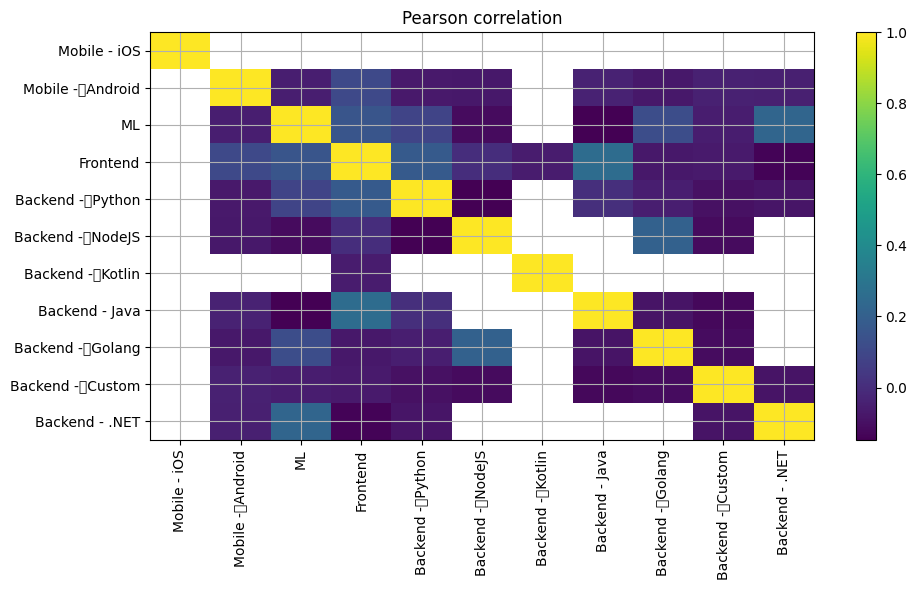

In [7]:
# Ячейка 7 — корреляция
def correlations(df, role_cols):
    pearson = df[role_cols].corr(method='pearson')
    spearman = df[role_cols].corr(method='spearman')
    return pearson, spearman

pearson, spearman = correlations(df, role_cols)
print("Pearson:")
display(pearson)
print("Spearman:")
display(spearman)

# Сохраним heatmap (matplotlib)
plt.figure(figsize=(10,8))
plt.imshow(pearson, aspect='auto', cmap='viridis')
plt.colorbar()
plt.xticks(range(len(pearson.columns)), pearson.columns, rotation=90)
plt.yticks(range(len(pearson.index)), pearson.index)
plt.title('Pearson correlation matrix')
plt.tight_layout()
plt.savefig('prodres_artifacts/pearson_corr.png', bbox_inches='tight')
plt.close()
print("Pearson heatmap saved to prodres_artifacts/pearson_corr.png")

pearson, spearman = correlations(df, role_cols)

print("Pearson")
display(pearson.round(2))

plt.figure(figsize=(10, 6))
plt.imshow(pearson, aspect="auto")
plt.colorbar()
plt.xticks(range(len(pearson.columns)), pearson.columns, rotation=90)
plt.yticks(range(len(pearson.index)), pearson.index)
plt.title("Pearson correlation")
plt.tight_layout()
plt.show()  # ← ВАЖНО



) missing from font(s) DejaVu Sans.lwth40000gn/T/ipykernel_13400/3914051371.py:13: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.lwth40000gn/T/ipykernel_13400/3914051371.py:14: UserWarning: Glyph 13 (
  plt.savefig(fname)


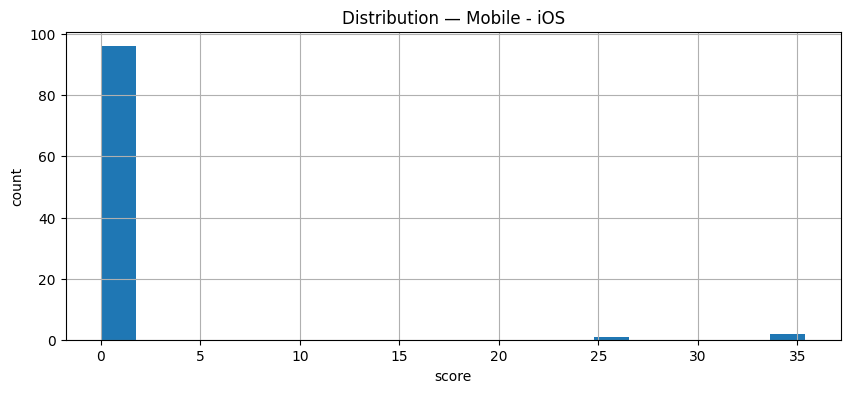

) missing from font(s) DejaVu Sans.-second-analytics/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


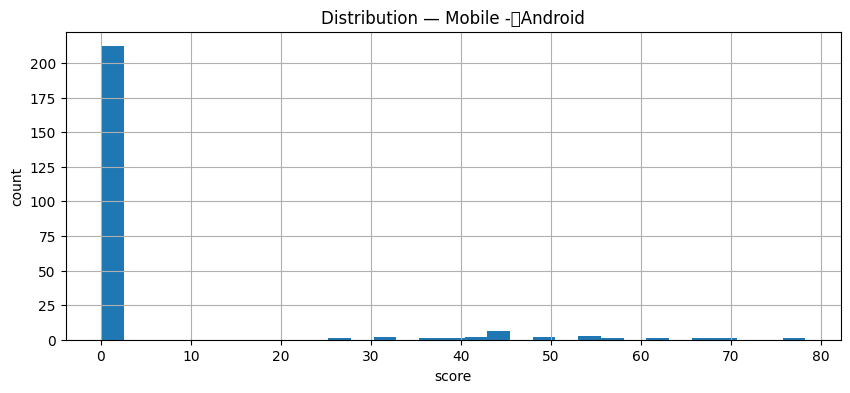

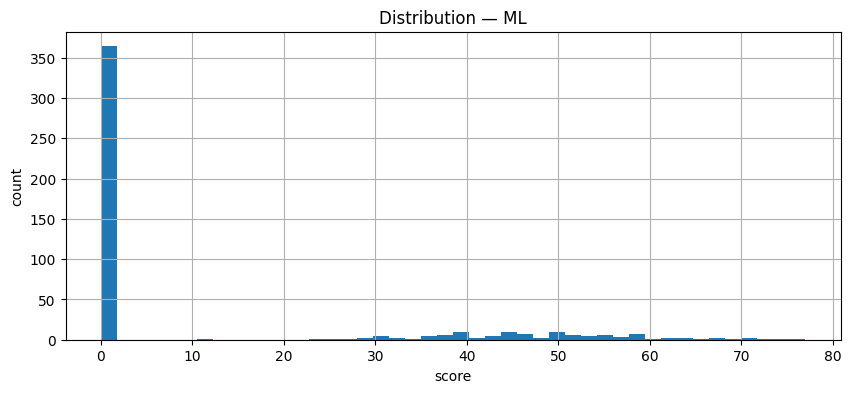

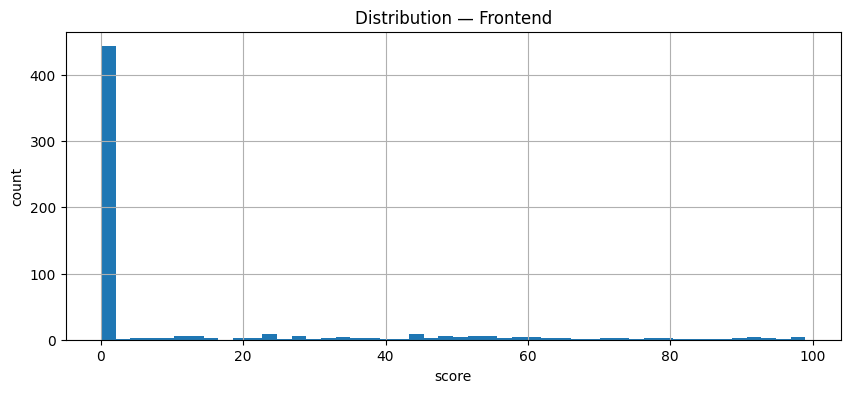

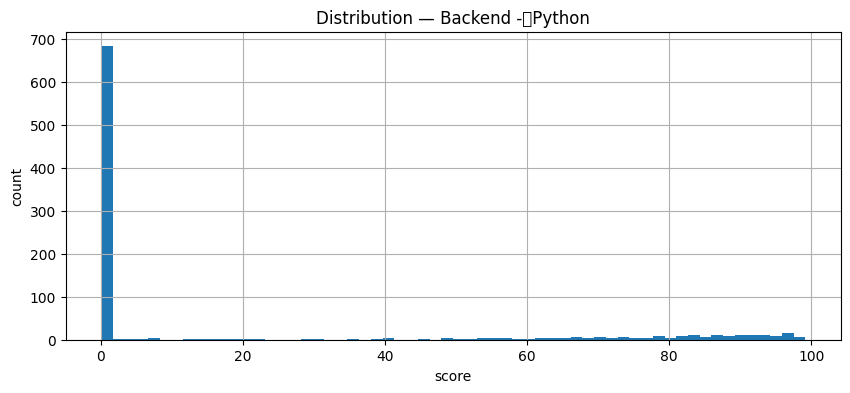

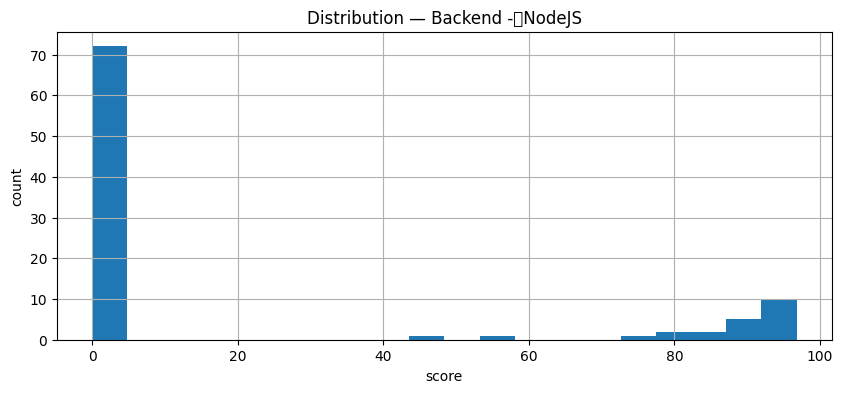

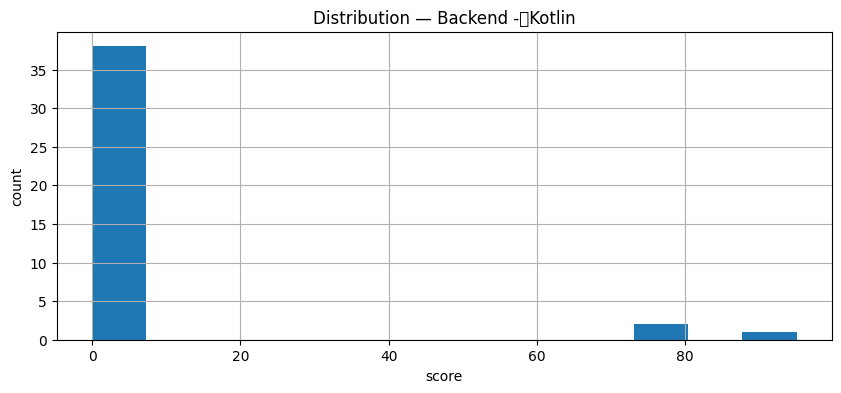

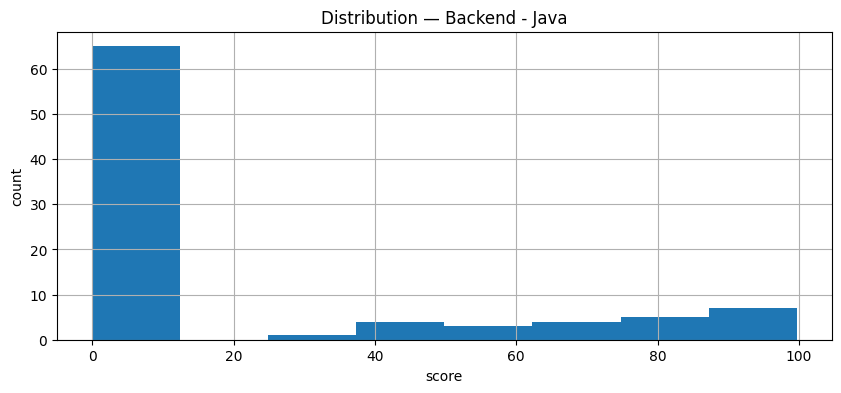

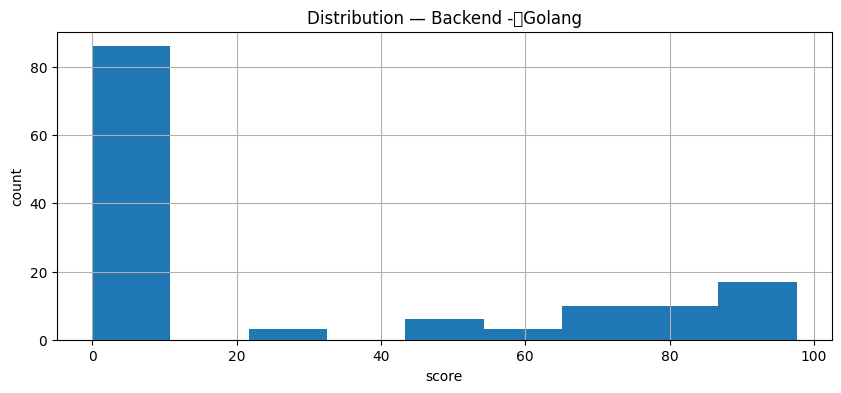

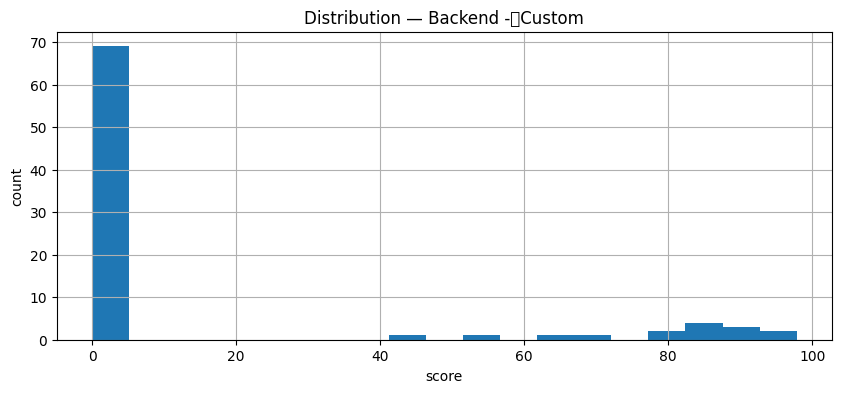

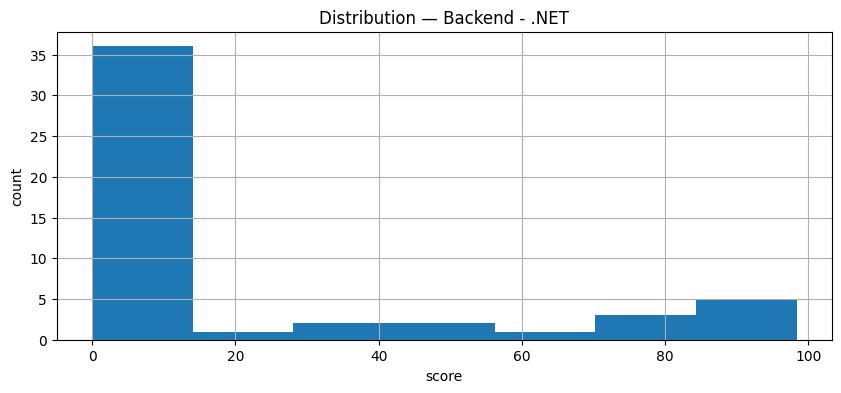

Гистограммы и bar-chart сохранены в prodres_artifacts/


) missing from font(s) DejaVu Sans.lwth40000gn/T/ipykernel_13400/3914051371.py:39: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.lwth40000gn/T/ipykernel_13400/3914051371.py:40: UserWarning: Glyph 13 (
  plt.savefig('prodres_artifacts/threshold_counts_per_role.png')


,40,60,80,90
Mobile - iOS,0,0,0,0
Mobile -\rAndroid,18,4,0,0
ML,82,14,0,0
Frontend,78,38,19,11
Backend -\rPython,193,170,114,62
Backend -\rNodeJS,22,20,18,13
Backend -\rKotlin,3,3,1,1
Backend - Java,22,16,11,5
Backend -\rGolang,46,38,26,14
Backend -\rCustom,15,13,11,3


) missing from font(s) DejaVu Sans.lwth40000gn/T/ipykernel_13400/3914051371.py:55: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.-second-analytics/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


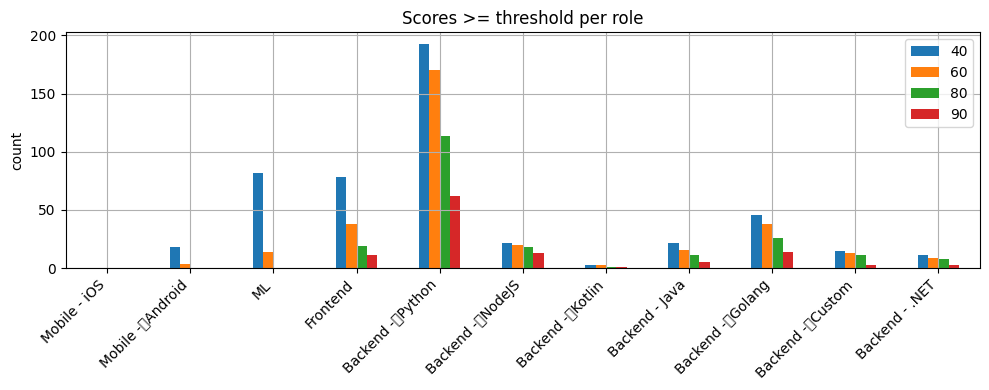

In [8]:
# Ячейка 8 — визуализации
def plot_histograms(df, role_cols, outdir='prodres_artifacts'):
    for c in role_cols:
        s = df[c].dropna()
        if len(s) == 0:
            continue
        plt.figure(figsize=(6,3))
        plt.hist(s, bins='auto')
        plt.title(f'Distribution — {c}')
        plt.xlabel('score')
        plt.ylabel('count')
        fname = f'{outdir}/hist_{c.replace(" ", "_").replace("-", "")}.png'
        plt.tight_layout()
        plt.savefig(fname)
        plt.close()

plot_histograms(df, role_cols)

for c in role_cols:
    s = df[c].dropna()
    if s.empty:
        continue

    plt.figure()
    plt.hist(s, bins="auto")
    plt.title(f"Distribution — {c}")
    plt.xlabel("score")
    plt.ylabel("count")
    plt.show()

# Bar chart: count >= thresholds per role
thresholds = [40,60,80,90]
counts_roles = {t: (df[role_cols] >= t).sum() for t in thresholds}
counts_df = pd.DataFrame(counts_roles)
counts_df.plot(kind='bar', figsize=(12,4))
plt.title('Counts of scores >= thresholds per role')
plt.ylabel('count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('prodres_artifacts/threshold_counts_per_role.png')
plt.close()
print("Гистограммы и bar-chart сохранены в prodres_artifacts/")

thresholds = [40, 60, 80, 90]
counts_df = pd.DataFrame(
    {t: (df[role_cols] >= t).sum() for t in thresholds}
)

display(counts_df)

counts_df.plot(kind="bar")
plt.title("Scores >= threshold per role")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



,PC1,PC2,cluster
0,-0.228000,0.049808,0
1,-2.229085,1.190475,2
2,-2.195168,1.171141,2
3,-1.663806,0.868253,0
4,2.805341,0.760018,1
...,...,...,...
1366,-1.956554,-0.295556,0
1367,-1.575752,-0.219472,0
1368,-0.872633,-0.078989,0
1369,-0.632240,-0.030958,0


PCA + KMeans plot saved to prodres_artifacts/pca_kmeans.png


,PC1,PC2,cluster
0,-0.228000,0.049808,0
1,-2.229085,1.190475,2
2,-2.195168,1.171141,2
3,-1.663806,0.868253,0
4,2.805341,0.760018,1
...,...,...,...
1366,-1.956554,-0.295556,0
1367,-1.575752,-0.219472,0
1368,-0.872633,-0.078989,0
1369,-0.632240,-0.030958,0


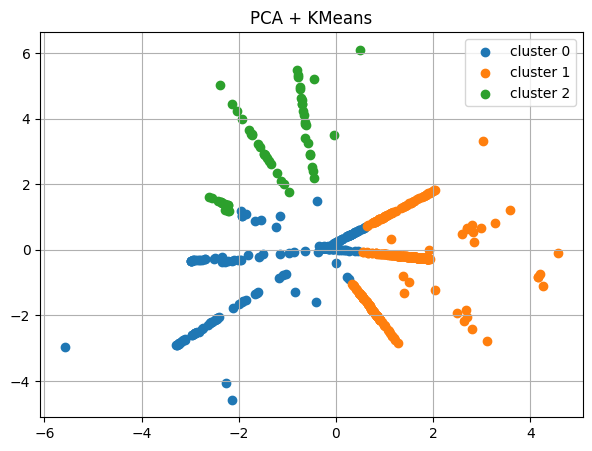

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Ячейка 9 — PCA + KMeans
def pca_and_cluster(df, role_cols, n_clusters=3):
    # Берём только строки/роли с хотя бы одним числом (или можно fillna=0)
    X = df[role_cols].fillna(0).values  # замена NaN на 0 — одна стратегия
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    Xp = pca.fit_transform(Xs)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(Xp)
    res = pd.DataFrame(Xp, columns=['PC1','PC2'], index=df.index)
    res['cluster'] = labels
    return res, pca, kmeans, scaler

if PCA is not None:
    pca_res, pca_model, kmeans_model, scaler = pca_and_cluster(df, role_cols, n_clusters=3)
    pca_plot = pca_res.copy()
    pca_plot['id'] = df[id_col].values
    # matplotlib scatter
    plt.figure(figsize=(7,5))
    for cl in sorted(pca_plot['cluster'].unique()):
        sub = pca_plot[pca_plot['cluster']==cl]
        plt.scatter(sub['PC1'], sub['PC2'], label=f'cluster {cl}', alpha=0.8)
    for i,row in pca_plot.iterrows():
        plt.text(row['PC1']+0.01, row['PC2']+0.01, str(row['id']), fontsize=8)
    plt.legend()
    plt.title('PCA 2D + KMeans clusters')
    plt.tight_layout()
    plt.savefig('prodres_artifacts/pca_kmeans.png')
    plt.close()
    display(pca_res)
    print("PCA + KMeans plot saved to prodres_artifacts/pca_kmeans.png")
else:
    print("scikit-learn не доступен — установи sklearn чтобы выполнить PCA/кластеризацию.")

pca_res, _, _, _ = pca_and_cluster(df, role_cols, n_clusters=3)

display(pca_res)

plt.figure(figsize=(7, 5))
for cl in sorted(pca_res["cluster"].unique()):
    sub = pca_res[pca_res["cluster"] == cl]
    plt.scatter(sub["PC1"], sub["PC2"], label=f"cluster {cl}")

plt.legend()
plt.title("PCA + KMeans")
plt.show()


In [10]:
# Ячейка 10 — интерактивная панель для порогов (опционально)
try:
    import ipywidgets as widgets
    from IPython.display import clear_output
    have_widgets = True
except Exception:
    have_widgets = False

if have_widgets:
    role_select = widgets.SelectMultiple(options=role_cols, description='Роли', rows=6)
    threshold_slider = widgets.IntSlider(value=40, min=0, max=100, step=1, description='Порог')
    run_button = widgets.Button(description='Показать')

    out = widgets.Output()
    display(widgets.HBox([role_select, threshold_slider, run_button]), out)

    def on_run(b):
        with out:
            clear_output()
            sel = list(role_select.value)
            t = threshold_slider.value
            if len(sel)==0:
                print("Выбери хотя бы 1 роль.")
                return
            subset = df[[id_col]+sel]
            mask = (subset[sel] >= t).any(axis=1)
            display(subset[mask])
            print(f"Найдено {mask.sum()} треков с >= {t} в выбранных ролях.")
    run_button.on_click(on_run)
else:
    print("ipywidgets не установлен — установи ipywidgets для интерактивности.")


Output()

In [11]:
# Ячейка 11 — экспорт основных артефактов и краткий PDF (при необходимости)
# Сохраняем очищенный CSV
df.to_csv('prodres_artifacts/prodres_clean.csv', index=False, encoding='utf-8-sig')
summary_roles.to_csv('prodres_artifacts/summary_roles.csv', encoding='utf-8-sig')
per_track.to_csv('prodres_artifacts/per_track_summary.csv', index=False, encoding='utf-8-sig')
tops_df.to_csv('prodres_artifacts/topk_by_role.csv', index=False, encoding='utf-8-sig')

print("Все ключевые CSV сохранены в prodres_artifacts/.")
print("Если хочешь — могу добавить генерацию PDF-отчёта (нужен reportlab / matplotlib).")


Все ключевые CSV сохранены в prodres_artifacts/.
Если хочешь — могу добавить генерацию PDF-отчёта (нужен reportlab / matplotlib).
